### GUI Grounding with Qwen2.5-VL

This notebook demonstrates how to use Qwen2.5-VL for GUI grounding. It takes a screenshot of a user's desktop and a query, and then uses the model to interpret the user's query on the screenshot.

#### \[Setup\]

Load visualization utils.

In [7]:
from PIL import Image, ImageDraw, ImageColor

def draw_point(image: Image.Image, point: list, color=None):
    if isinstance(color, str):
        try:
            color = ImageColor.getrgb(color)
            color = color + (128,)  
        except ValueError:
            color = (255, 0, 0, 128)  
    else:
        color = (255, 0, 0, 128)  

    overlay = Image.new('RGBA', image.size, (255, 255, 255, 0))
    overlay_draw = ImageDraw.Draw(overlay)
    radius = min(image.size) * 0.05
    x, y = point

    overlay_draw.ellipse(
        [(x - radius, y - radius), (x + radius, y + radius)],
        fill=color
    )
    
    center_radius = radius * 0.1
    overlay_draw.ellipse(
        [(x - center_radius, y - center_radius), 
         (x + center_radius, y + center_radius)],
        fill=(0, 255, 0, 255)
    )

    image = image.convert('RGBA')
    combined = Image.alpha_composite(image, overlay)

    return combined.convert('RGB')

Load model and processor.

In [1]:
import torch
from transformers import Qwen2_5_VLProcessor, Qwen2_5_VLForConditionalGeneration

model_path = "Qwen/Qwen2.5-VL-7B-Instruct"
processor = Qwen2_5_VLProcessor.from_pretrained(model_path)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(model_path, torch_dtype=torch.bfloat16, attn_implementation="flash_attention_2",device_map="auto")

/cpfs01/data/shared/Group-m6/zeyu.czy/workspace/pythonfile/xlang/yiheng/DamoAGI/qwen2.5vl_cookbook/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`Qwen2_5_VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
Loading checkpoint shards: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


#### 1. GUI Grounding



In [10]:
import json
from PIL import Image
from IPython.display import display
from agent_function_call import ComputerUse
from qwen_agent.llm.fncall_prompts.nous_fncall_prompt import (
    NousFnCallPrompt,
    Message,
    ContentItem,
)
from transformers.models.qwen2_5_vl.image_processing_qwen2_5_vl import smart_resize

def perform_gui_grounding(screenshot_path, user_query, model, processor):
    """
    Perform GUI grounding using Qwen model to interpret user query on a screenshot.
    
    Args:
        screenshot_path (str): Path to the screenshot image
        user_query (str): User's query/instruction
        model: Preloaded Qwen model
        processor: Preloaded Qwen processor
        
    Returns:
        tuple: (output_text, display_image) - Model's output text and annotated image
    """
    # ... existing code for imports ...
    
    # Open and process image
    dummy_image = Image.open(screenshot_path)
    resized_height, resized_width = smart_resize(
        dummy_image.height,
        dummy_image.width,
        factor=processor.image_processor.patch_size * processor.image_processor.merge_size,
        min_pixels=processor.image_processor.min_pixels,
        max_pixels=processor.image_processor.max_pixels,
    )
    
    # Initialize computer use function
    computer_use = ComputerUse(
        cfg={"display_width_px": resized_width, "display_height_px": resized_height}
    )

    # Build messages
    message = NousFnCallPrompt.preprocess_fncall_messages(
        messages=[
            Message(role="system", content=[ContentItem(text="You are a helpful assistant.")]),
            Message(role="user", content=[
                ContentItem(text=user_query),
                ContentItem(image=f"file://{screenshot_path}")
            ]),
        ],
        functions=[computer_use.function],
        lang=None,
    )
    message = [msg.model_dump() for msg in message]

    # Process input
    text = processor.apply_chat_template(message, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[text], images=[dummy_image], padding=True, return_tensors="pt").to('cuda')

    # Generate output
    output_ids = model.generate(**inputs, max_new_tokens=2048)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)[0]

    # Parse action and visualize
    action = json.loads(output_text.split('<tool_call>\n')[1].split('\n</tool_call>')[0])
    display_image = dummy_image.resize((resized_width, resized_height))
    display_image = draw_point(dummy_image, action['arguments']['coordinate'], color='green')
    
    return output_text, display_image

<tool_call>
{"name": "computer_use", "arguments": {"action": "left_click", "coordinate": [1890, 722]}}
</tool_call>


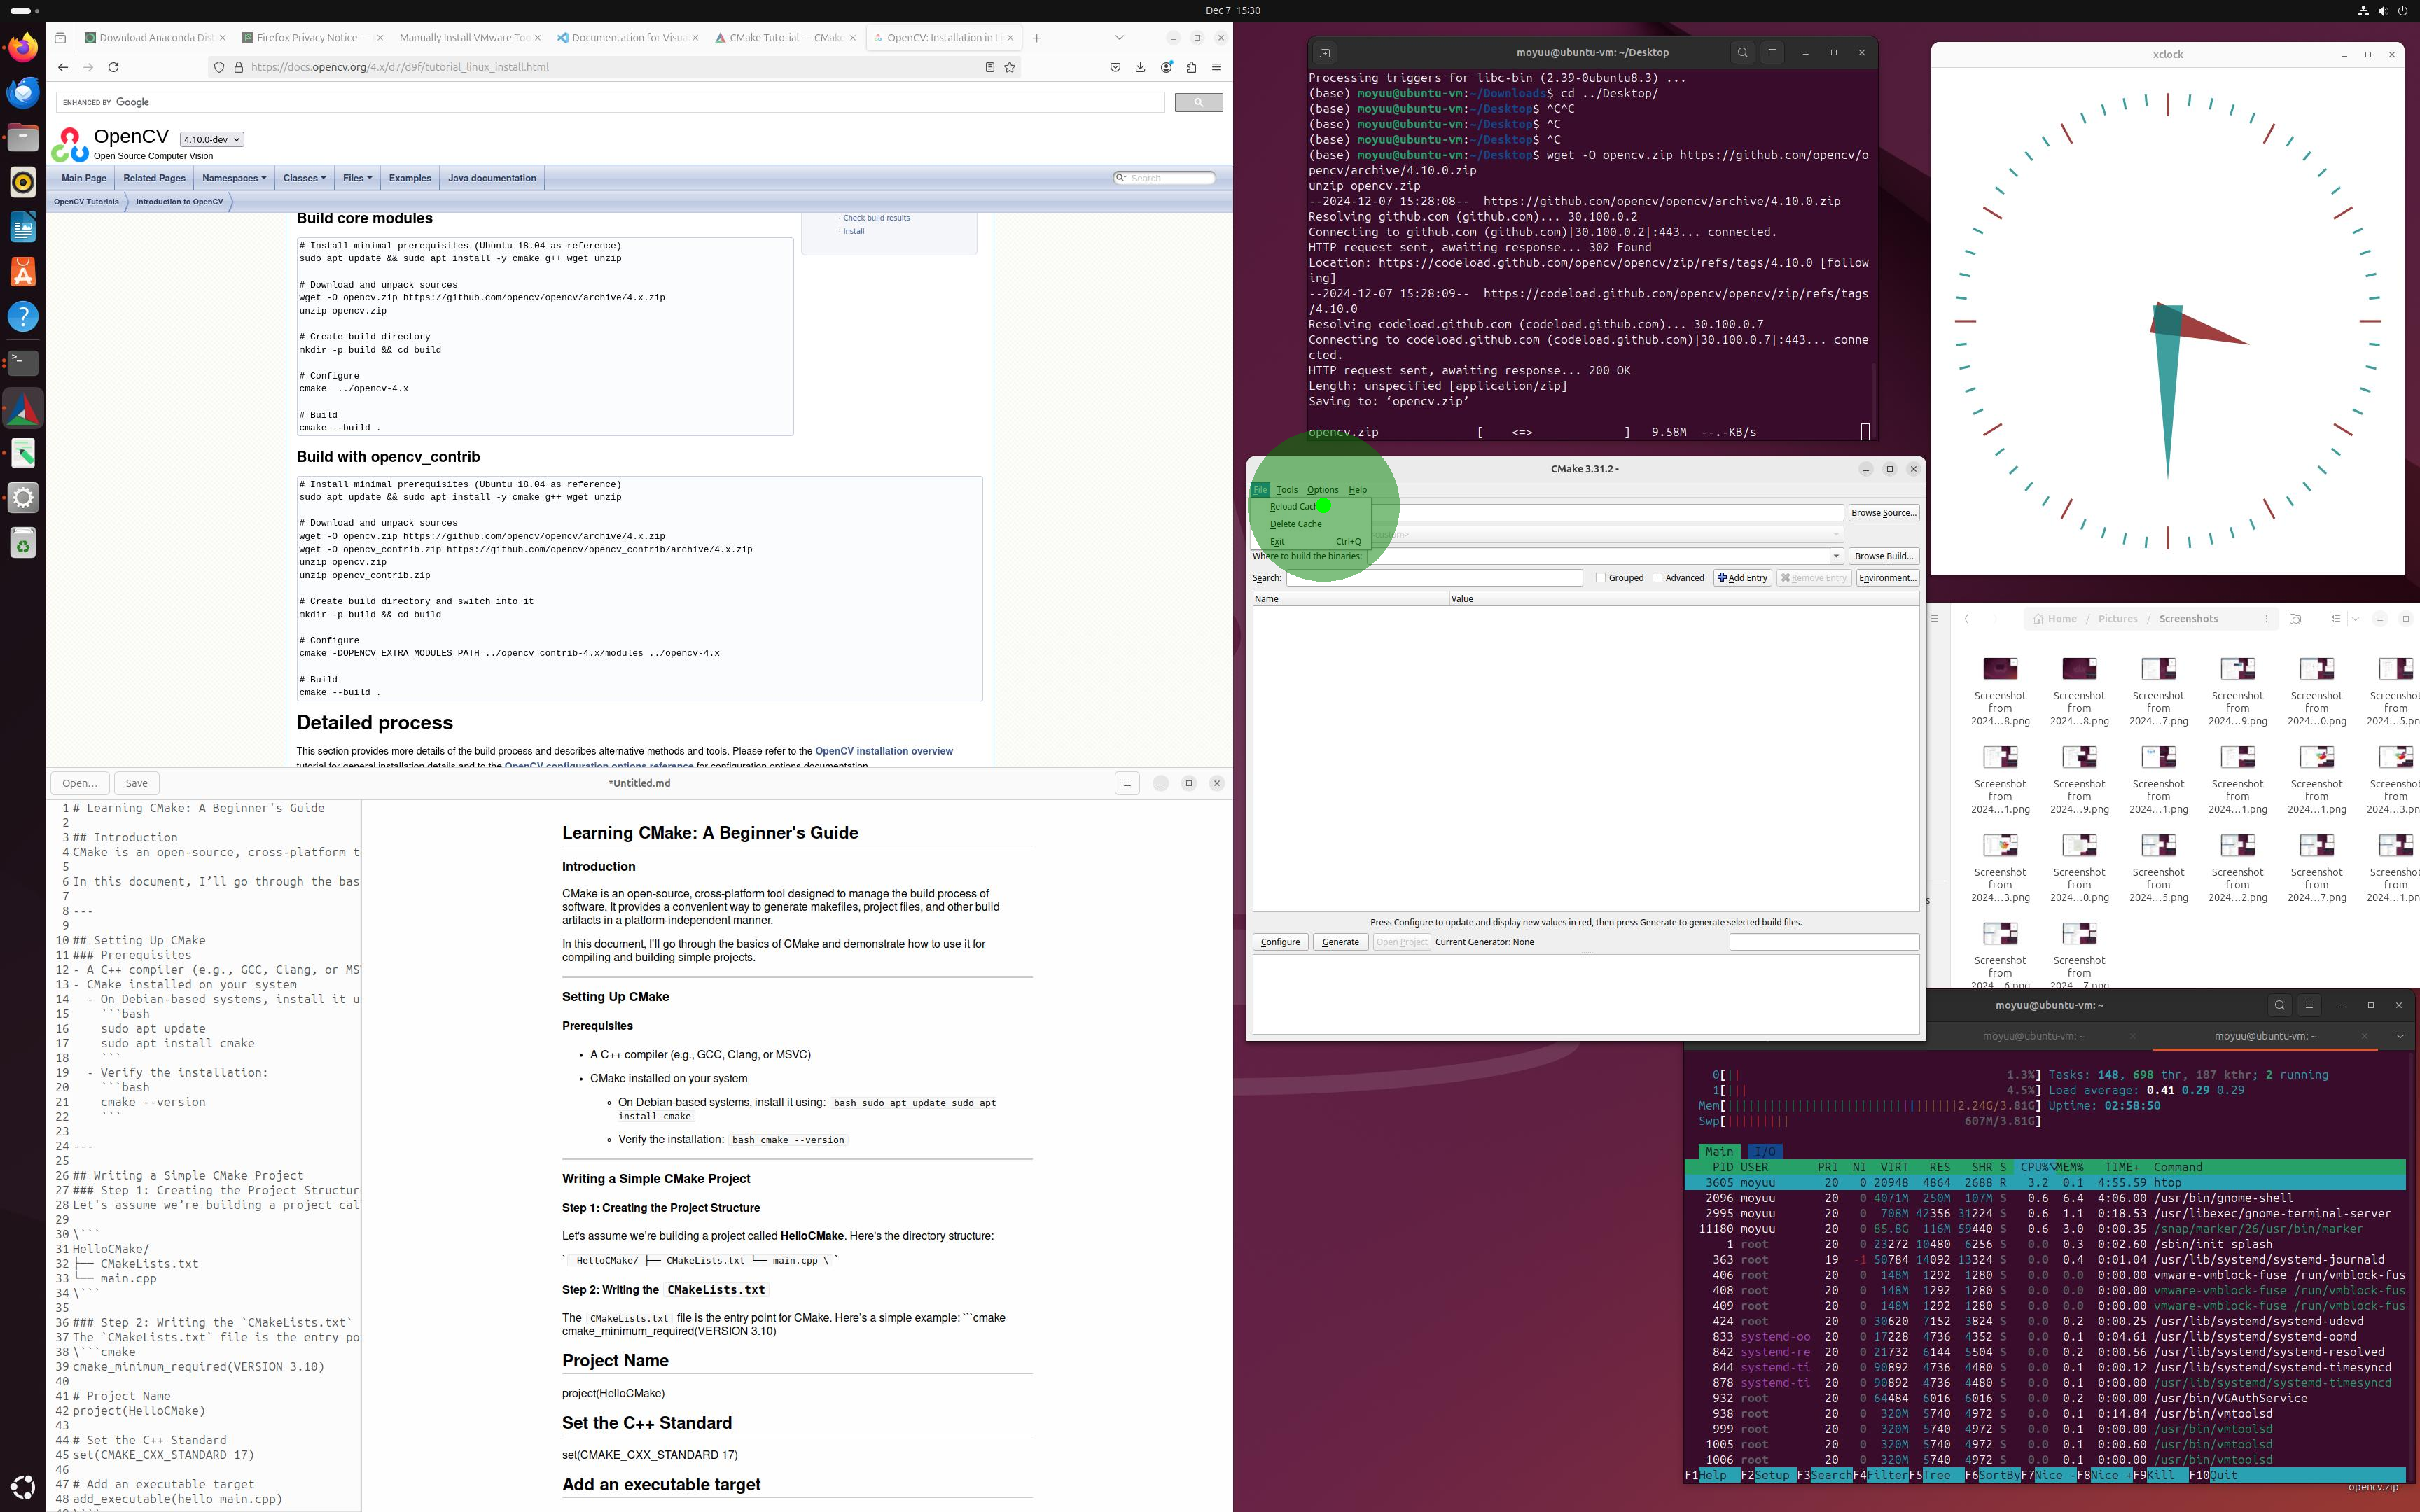

In [11]:
# Example usage
screenshot = "assets/computer_use/computer_use1.jpeg"
user_query = 'Reload cache'
output_text, display_image = perform_gui_grounding(screenshot, user_query, model, processor)

# Display results
print(output_text)
display(display_image)

<tool_call>
{"name": "computer_use", "arguments": {"action": "left_click", "coordinate": [1230, 769]}}
</tool_call>


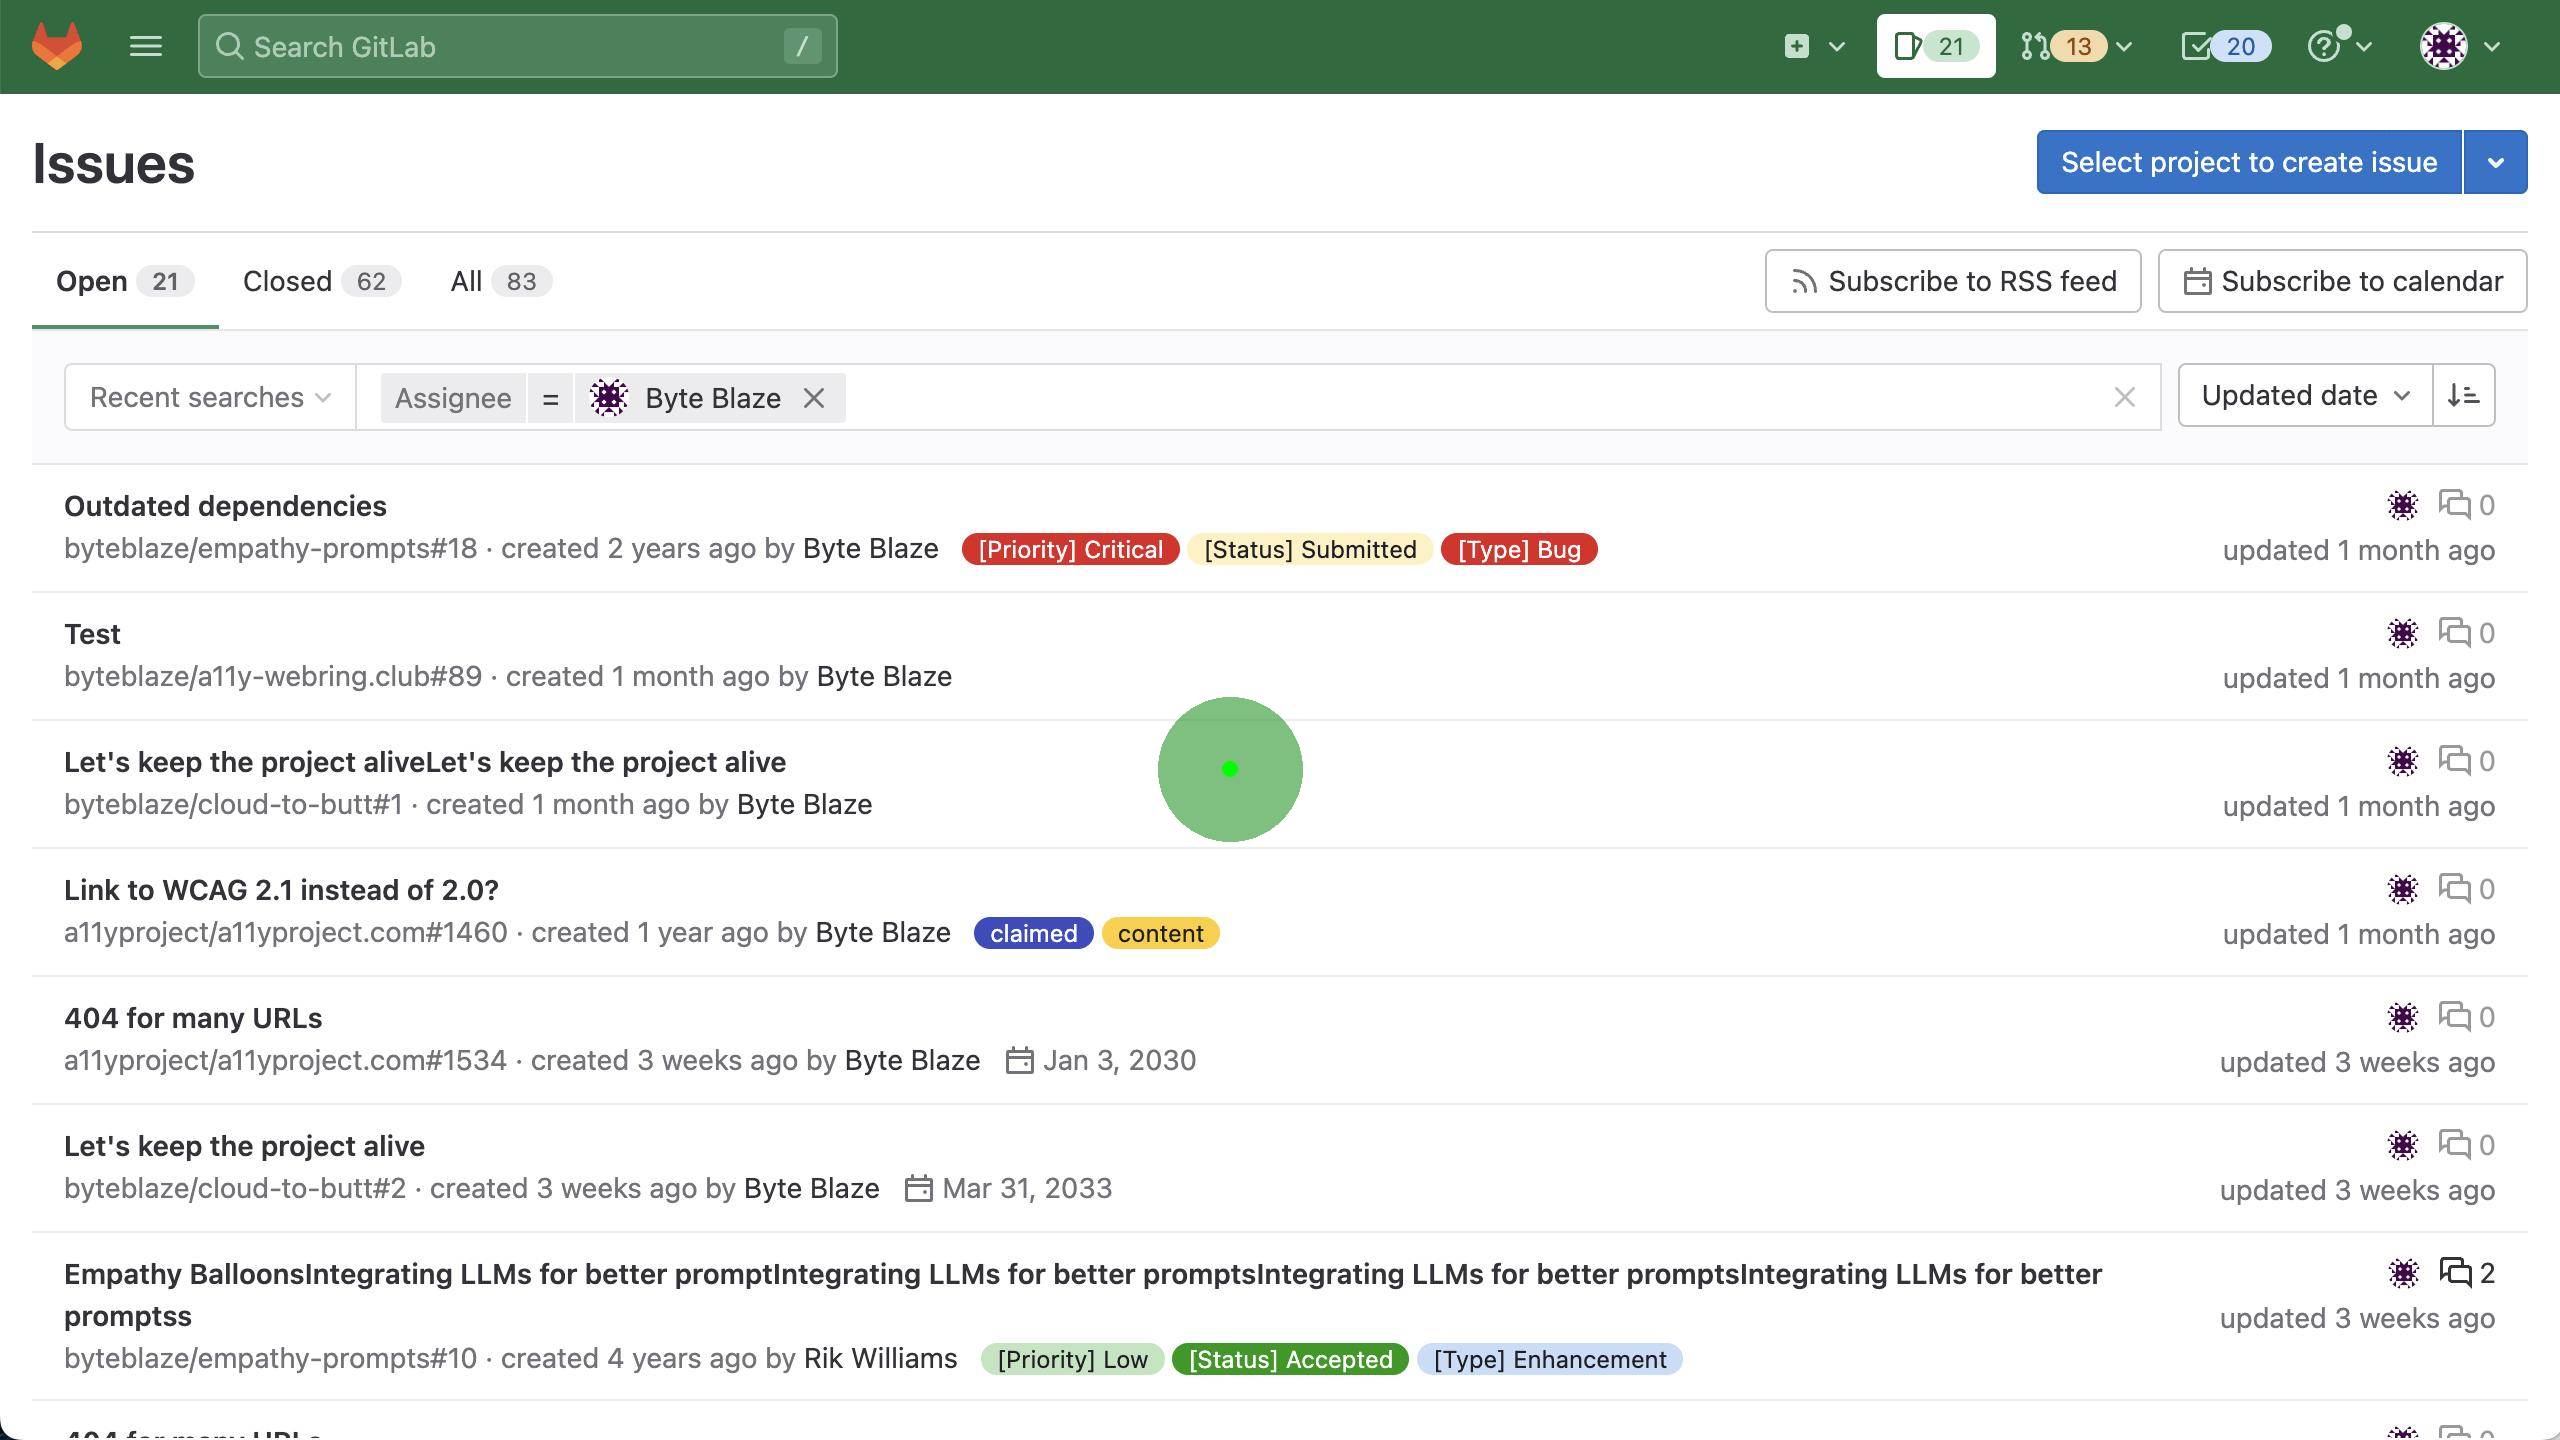

In [17]:
# Example usage
screenshot = "assets/computer_use/computer_use2.jpeg"
user_query = 'open the third issue'
output_text, display_image = perform_gui_grounding(screenshot, user_query, model, processor)

# Display results
print(output_text)
display(display_image)